# Creating Spectrograms from Audio Files
*Author: Ee Kin Chin*

This notebook shows you how to take the audio recordings of heatbeats and turn them into spectrograms.  In doing this, you are creating a visual representation of sound to classify the audiofiles with VisualAI.  The dataset for this example was taken from Bently and colleagues (2011) Pascal Classifying Heart Sounds Challenge: 

*Bentley, P., Nordehn, G., Coimbra, M., Mannor, S., & Getz, R. (2011). The pascal classifying heart sounds challenge 2011 (chsc2011) results. See http://www.peterjbentley.com/heartchallenge/index.html.*

### Import packages

In [81]:
import pandas as pd
import os
import glob
from PIL import Image
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import shutil
import datarobot as dr

### Create functions for transforming audio files to spectrograms

The code below turns the soundfiles into spectrograms. 

In [82]:
def read_audio_file(file_path):
    """ Reads the audio frames and metadata from a file or stream.

    This is a thin wrapper around SoundFile to process the audio file, but transposes the audio
    frames to match the form expected by librosa.

    Parameters
    ----------
    file_path : str
        The file to open

    Returns
    -------
    audio_frames_transposed : numpy.ndarray or type(out)
        Transposed audio frames.  A two-dimensional NumPy (frames x channels) array is returned.
        If the sound file has only one channel, a one-dimensional array is returned.
    sample_rate : int
        The sample rate of the file.
    bit_depth : int
        The subtype of the sound file.
    channels : int
        The number of channels of the file.
    """
    audio = soundfile.SoundFile(file_path)
    audio_frames_transposed = audio.read(frames=-1, dtype=np.float32, always_2d=False).T
    return (audio_frames_transposed, audio.samplerate, audio.subtype, audio.channels)



def scale_minmax(X, min=0.0, max=255.0):
    """ rescaling from dB to image pixel values from 0 to 255
    """
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled.astype(np.uint8)


def raw_audio_frames_to_logmelspectrogram(raw_audio, conf):
    melspectrogram = librosa.feature.melspectrogram(
        raw_audio,
        sr=conf.sampling_rate,
        hop_length=conf.hop_length,
        n_fft=conf.window_length,
        window=conf.window_function,
    )

    logmelspectrogram = librosa.power_to_db(melspectrogram)
    logmelspectrogram = scale_minmax(logmelspectrogram).astype('uint8')
    cmap = plt.get_cmap('magma')
    rgba_logmelspectrogram = cmap(logmelspectrogram)
    rgb_logmelspectrogram = (np.delete(rgba_logmelspectrogram, 3, 2) * 255).astype('uint8')
    return rgb_logmelspectrogram

### Set up file paths

Setup files and filepaths to create the final data folder. 

In [86]:
sound_base_folder = 'YOURFILEPATH/453_923_bundle_archive/'
set_b_csv = os.path.join(sound_base_folder, 'set_b.csv')
set_b_folder = os.path.join(sound_base_folder, 'set_b')
set_a_folder = os.path.join(sound_base_folder, 'set_a')

all_wav_files = glob.glob(os.path.join(set_b_folder, '*.wav'))
final_dataset_folder = os.path.join(sound_base_folder, 'datarobot_heartbeat_audio')
os.makedirs(final_dataset_folder, exist_ok=True)


### Audio Files

Setup audio pre-processing parameters. 

In [87]:
all_raw_audio = []
all_duration = []
all_shapes = []
all_sample_rates = []
all_bit_depth = []
all_channels = []

for wav_file in all_wav_files:
    raw_audio, sample_rate, subtype, channels = read_audio_file(wav_file)
    all_raw_audio.append(raw_audio)
    all_shapes.append(raw_audio.shape[channels-1])
    all_duration.append(raw_audio.shape[channels-1] / sample_rate)
    all_sample_rates.append(sample_rate)
    all_bit_depth.append(subtype)
    all_channels.append(channels)

In [89]:
set(all_sample_rates), set(all_bit_depth), set(all_channels), np.max(all_shapes)

({4000}, {'PCM_16'}, {1}, 111468)

### Plot different bandwidths.

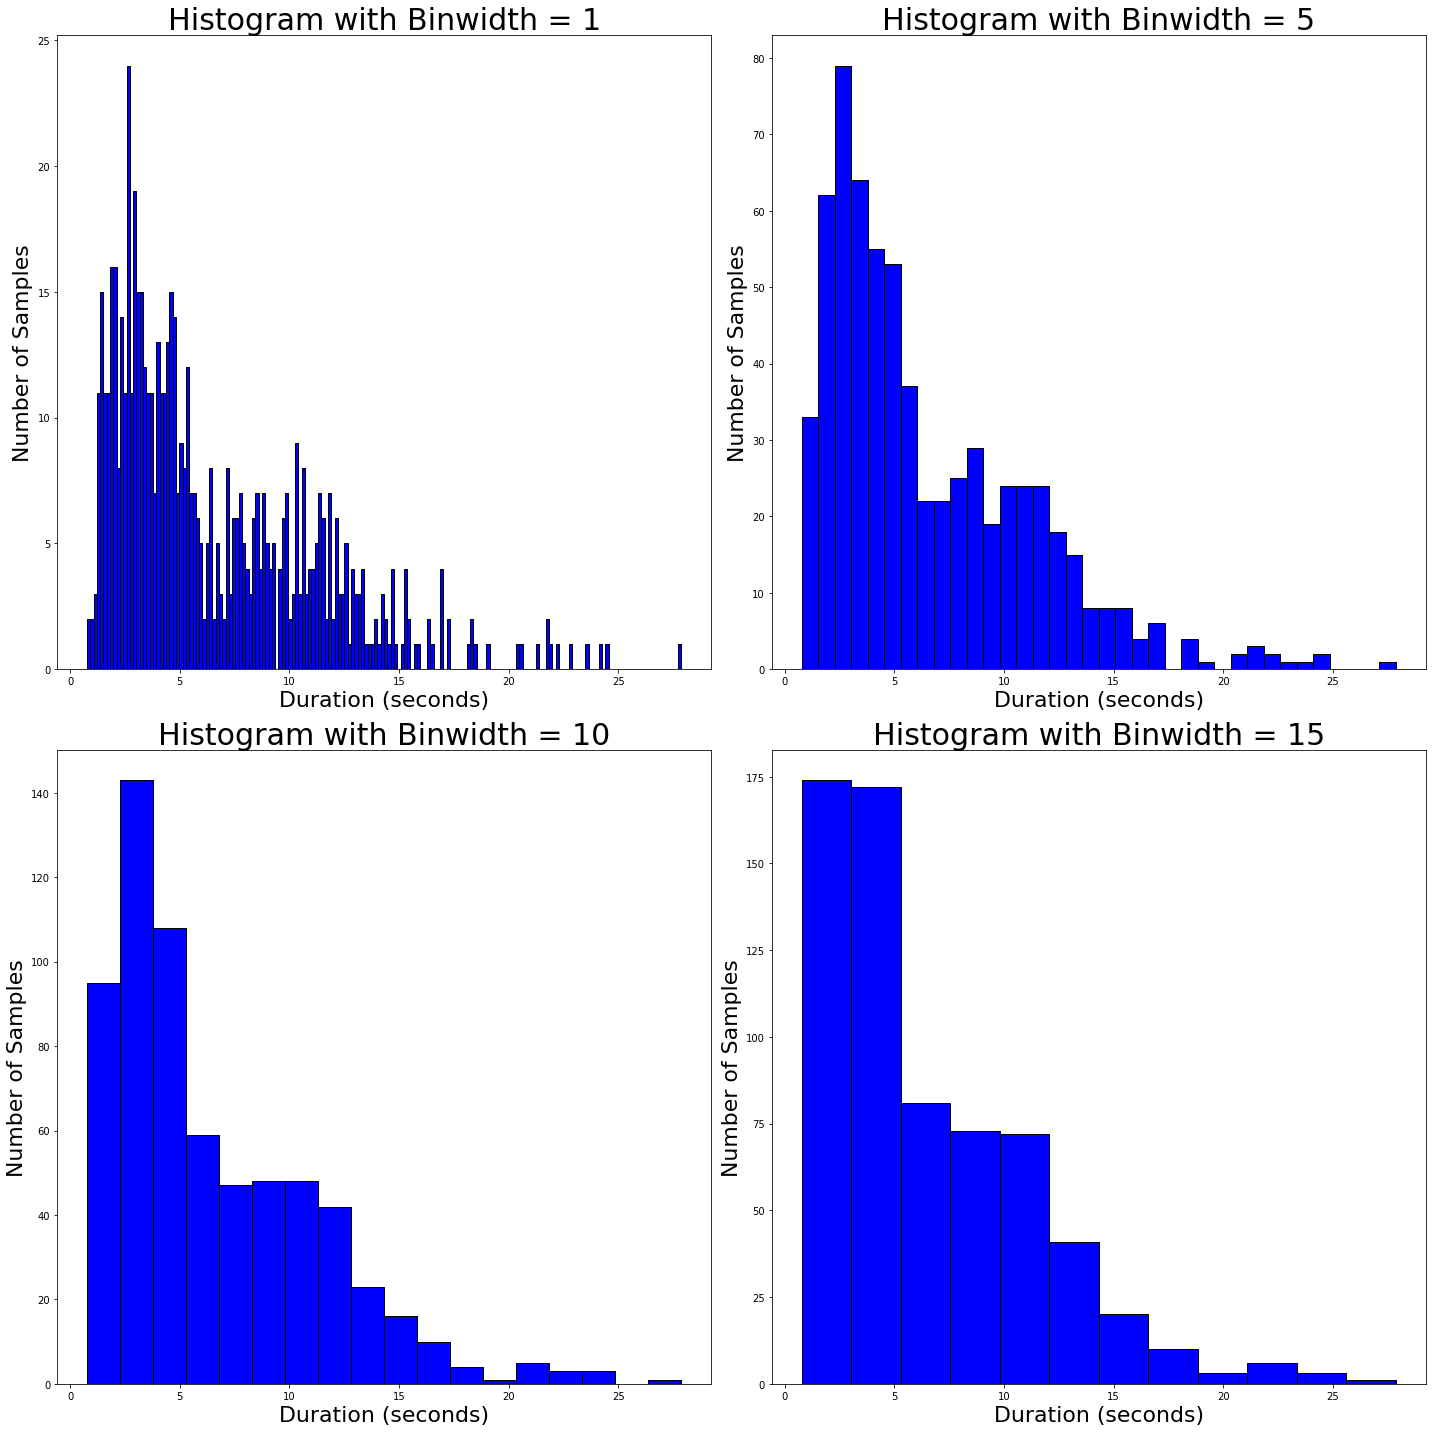

In [90]:

# Show 4 different binwidths
plt.figure(figsize=(20,20))

for i, binwidth in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(all_duration, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
    ax.set_xlabel('Duration (seconds)', size = 22)
    ax.set_ylabel('Number of Samples', size= 22)

plt.tight_layout()
plt.show()

### Set up audio parameters

In [91]:

class AudioConf:
    # Preprocessing settings
    sampling_rate = 44100
    window_function = 'hanning'
    hop_length_percentage = 0.25 # determines the amount of overlap, higher means more frames
    window_length = 2048  # length of the FFT window
    hop_length = int(window_length * hop_length_percentage)  # number of samples between successive frames.
        

### Setup CSV File

In [92]:
train = pd.read_csv(set_b_csv)

In [93]:
train.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [94]:
labels = train['label'].values.tolist()
fname = train['fname'].values.tolist()

### Create Spectral Images

Create the spectrograms from the files in all_wav_files and put them in the final_dataset_folder.  

In [98]:
all_wav_files = ['/'.join(wav_file.split('/')[-2:]) for wav_file in all_wav_files]

In [99]:
for idx, raw_audio in enumerate(all_raw_audio):
    
    logmelspectrogram = raw_audio_frames_to_logmelspectrogram(
        raw_audio,
        AudioConf,
    )
    filename = all_wav_files[idx].split('/')[-1].replace('__', '_')
    identifier = '_' + '_'.join(filename.split('_')[-4:])
    indexes = [idx for idx, fn in enumerate(fname) if identifier in fn]
    if len(indexes) == 1:
        label = labels[indexes[0]]
        pillow_image = Image.fromarray(logmelspectrogram)
        label_dir_path = os.path.join(final_dataset_folder, label)
        image_file_path = os.path.join(label_dir_path, '{}.png'.format(filename.split('.')[0]))
        os.makedirs(label_dir_path, exist_ok=True)
        pillow_image.save(image_file_path, "PNG")
    

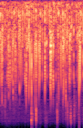

In [100]:
pillow_image

### Create Zipped File for DataRobot

Zip the folder to ingest into DataRobot. 

In [104]:

shutil.make_archive("zipped_datarobot_audio", 'zip', final_dataset_folder)

'/Users/emily.webber/Documents/Heartbeat Update/zipped_datarobot_audio.zip'

### Connect to DataRobot

In [105]:
DRToken = 'YOUR_TOKEN'
DREndpoint = 'https://app.datarobot.com/api/v2'

In [108]:
dr.Client(token= DRToken, 
          endpoint= DREndpoint)

### Setup Project

In [112]:
project = dr.Project.create("YOUR_FILEPATH/zipped_datarobot_audio.zip", 
                            project_name='Project_Name')

### Run Project

In [113]:
project.set_target(target='class',
                   mode=dr.AUTOPILOT_MODE.FULL_AUTO,
                   worker_count = -1)

Project(Heartbeat Updated 2)

### Model Evaluation

**Select the top model.**

Create a list of the models and rank them by the optimization metric.  Then select the top model. 

In [115]:
models = project.get_models(order_by = '-metric')
model = models[0]
model

Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)')

**Get the confusion chart.**

The confusion chart can help you understand how your model performed. 

In [139]:
cc = model.get_confusion_chart(source='validation')
cc.class_metrics
pd.DataFrame (cc.class_metrics)

,class_name,actual_count,predicted_count,f1,recall,precision,confusion_matrix_one_vs_all,was_actual_percentages,was_predicted_percentages
0,extrastole,8,0,0.000000,0.000000,0.000000,"[[66, 0], [8, 0]]","[{'other_class_name': 'extrastole', 'percentag...","[{'other_class_name': 'extrastole', 'percentag..."
1,murmur,17,12,0.758621,0.647059,0.916667,"[[56, 1], [6, 11]]","[{'other_class_name': 'extrastole', 'percentag...","[{'other_class_name': 'extrastole', 'percentag..."
2,normal,49,62,0.864865,0.979592,0.774194,"[[11, 14], [1, 48]]","[{'other_class_name': 'extrastole', 'percentag...","[{'other_class_name': 'extrastole', 'percentag..."
